# Downloads raw data

In [24]:
import API.send_request as req
import json

# match information
match_id = 'NA1_4100487908'
server = 'americas'
api_key = 'RGAPI-20020b55-e696-4059-b72e-ba30cd29777c'
save_path = '../../Dataset/League_of_Legends/challenger_raw/'

sender = req.match_req_sender(server, api_key)
meta = sender.req_match(match_id)
timeline = sender.req_timeline(match_id)

if (meta != None and timeline != None):
    meta = meta.json()
    timeline = timeline.json()

    # save json file
    with open(save_path+f"{match_id}.json", "w") as file_match:
        json.dump(meta, file_match, indent=4)

    with open(save_path+f"{match_id}_timeline.json", "w") as file_timeline:
        json.dump(timeline, file_timeline, indent=4)

Got match data with match id=NA1_4100487908 successfuly.
Got timeline data with match id=NA1_4100487908 successfuly.


# Extract features

In [25]:
%rm -rf ../../Dataset/League_of_Legends/challenger_raw/.ipynb_checkpoints
%rm -rf ../../Dataset/League_of_Legends/challenger_csv/*

from Utilities.timeline_extractor import extract
from Utilities.win_lose_extractor import challengers

extract('../../Dataset/League_of_Legends', '/challenger_raw/', '/challenger_csv/')
challengers()

100%|██████████| 8/8 [00:00<00:00, 6540.82it/s]


# Tensorize

In [26]:
%rm -rf ../../Dataset/League_of_Legends/challenger_csv/.ipynb_checkpoints

import pandas as pd
from os import listdir
from tqdm import tqdm
from torch import tensor, zeros

pickle_route = "../../Dataset/League_of_Legends/features_tensor/challenger/"

print("Processing flipped train features...")
csv_route = "../../Dataset/League_of_Legends/challenger_csv/"
feat_list = listdir(csv_route)

for file_name in tqdm(feat_list):
    file = pd.read_csv(f"{csv_route}{file_name}")
    file = file.sort_values(by='time', ascending=False, axis=0, ignore_index=True)
    file = file[file['is_valid'] == True]
    file = file.loc[:,"time":"event_weight"]
    players = []
    for idx in range(0, 10):
        player = file[file["player"] == idx+1].drop(columns=["player"])
        temp_feature = tensor([player.values]) if len(player) != 0 else zeros([1, 1, 30])
        # if temp_feature.size()[1] > 1: temp_feature = temp_feature.flip(1)
        players.append(temp_feature)
    pd.to_pickle(players, f"{pickle_route}{file_name[0:-4]}.pkl")
print("")

Processing flipped train features...


100%|██████████| 4/4 [00:00<00:00, 102.19it/s]

# Tensorize (by team)

In [27]:
%rm -rf ../../Dataset/League_of_Legends/challenger_csv/.ipynb_checkpoints

import pandas as pd
from os import listdir
from tqdm import tqdm
from torch import tensor, zeros

csv_route = "../../Dataset/League_of_Legends/challenger_csv/"
pickle_route = "../../Dataset/League_of_Legends/features_tensor/challenger_by_team/"
feat_list = listdir(csv_route)

print("Processing flipped test features...")

for file_name in tqdm(feat_list):
    f_file = pd.read_csv(f"{csv_route}{file_name}")
    f_file = f_file.loc[:,"time":"event_weight"]

    blue = f_file[f_file['player'] < 5].drop(columns=['player'])
    red = f_file[f_file['player'] >= 5].drop(columns=['player'])

    blue_features = tensor([blue.values]) if len(blue) != 0 else zeros([1, 1, 30])
    if blue_features.shape[1] > 1: blue_features = blue_features.flip(1)

    red_features = tensor([red.values]) if len(red) != 0 else zeros([1, 1, 30])
    if red_features.shape[1] > 1: red_features = red_features.flip(1)

    features = [blue_features, red_features]
    pd.to_pickle(features, f"{pickle_route}{file_name[0:-4]}.pkl")
print("")

Processing flipped test features...


100%|██████████| 4/4 [00:00<00:00, 150.58it/s]

# Test


In [28]:
%rm ./processed_ftr/result_predict_challenger.csv ./processed_ftr/scores_challenger.csv
%rm ./processed_ftr/challenger_g3.csv ./processed_ftr/challenger_g3_score.csv

import pasta_spaghettini as spa
from tqdm import tqdm
import pandas as pd
import torch

g3 = False

if g3:
    hp = {"epochs": 1, "learning_rate": 0.01, "num_layers": 2, "hidden_size": 8, "input_size": 30}
    route = "../../Dataset/League_of_Legends/features_tensor/challenger_by_team/"
    param_path = './parameters/param_spa_g3'
else:
    hp = {"epochs": 1, "learning_rate": 0.01, "num_layers": 1, "hidden_size": 8, "input_size": 30}
    route = "../../Dataset/League_of_Legends/features_tensor/challenger/"
    param_path = '_spaghettini'

PASTA = spa.PASTA(hp["input_size"], hp["hidden_size"], hp["num_layers"], hp["learning_rate"])
PASTA.load_parameter(param_path)

test_match_result_ftr = pd.read_csv("./processed_csvs/challenger_result.csv")
total_rows = test_match_result_ftr.shape[0]

confusion_matrix, c_label = [0, 0, 0, 0], ["TN", "FP", "FN", "TP"]

print("--test start--")
for idx, row in tqdm(test_match_result_ftr.iterrows(), ncols=50, total=total_rows):
    match_id, win = row["match_no"], row["win"]
    features = pd.read_pickle(f"{route}{match_id}.pkl")

    if g3: winner, predict = PASTA.test(features, win, match_id)
    else: winner, predict = PASTA.test(features, win, match_id, postfix='challenger')

    correct = 2*winner + predict
    confusion_matrix[correct] += 1

for idx in range(0, 4):
    print(f"{c_label[idx]}: {confusion_matrix[idx]} / ", end="")
    
torch.cuda.empty_cache()

rm: cannot remove './processed_ftr/challenger_g3.csv': No such file or directory
rm: cannot remove './processed_ftr/challenger_g3_score.csv': No such file or directory
--test start--


100%|███████████████| 4/4 [00:00<00:00, 69.04it/s]

TN: 4 / FP: 0 / FN: 0 / TP: 0 / 

# Extract metadata

In [29]:
%rm -rf ./processed_csvs/challengers/*
%rm -rf ../../Dataset/League_of_Legends/challenger_raw/.ipynb_checkpoints

import Utilities.meta_extractor as me
import Utilities.meta_analyzer as ma
import Utilities.meta_concat_total_score as mc

me.extract()
ma.analyze()
mc.concat(g3=False)

# Challenger games list

In [30]:
%rm -rf ../../Dataset/League_of_Legends/features_tensor/challenger_by_team/.ipynb_checkpoints

import pandas as pd
from os import listdir

path = '../../Dataset/League_of_Legends/features_tensor/challenger_by_team/'
games = listdir(path)
games

['KR_5548846548.pkl',
 'NA1_4100414087.pkl',
 'KR_5534775864.pkl',
 'KR_5534661935.pkl',
 'KR_5531638748.pkl',
 'NA1_4100487908.pkl',
 'KR_5534298194.pkl',
 'KR_5534402610.pkl',
 'KR_5531651538.pkl',
 'KR_5548791013.pkl',
 'NA1_4098819207.pkl',
 'KR_5550089007.pkl',
 'KR_5558295613.pkl',
 'NA1_4100472750.pkl']

# Score analysis

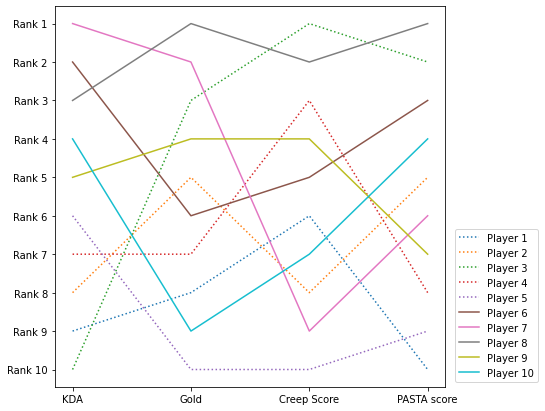

In [31]:
import experiment_vis_leaderboard as lb
import matplotlib.pyplot as plt

# match = 'KR_5531638748' # Plaayer 5: Not very good according to traditional indicators, but PASTA score is high
# match = 'KR_5548791013'
# match = 'KR_5558295613'
match = 'NA1_4100487908'

data, isWin = lb.load_leaderboard_graph(match, challenger=True)

players = []
for index, series in data.iterrows():
    ranks = series.tolist()
    ranks = [11-rank for rank in ranks]
    players.append(ranks)

x_axis = data.columns.tolist()

fig = plt.figure(figsize=(7, 7))

##### total plot #####
for i in range(len(players)):
    line = '-' if isWin[i] else ':'
    plt.plot(x_axis, players[i], linestyle=line, label=f'Player {i+1}')
plt.yticks([i+1 for i in range(10)], [f'Rank {10-i}' for i in range(10)])
plt.legend(bbox_to_anchor=(0.5, 0, 0.75, 0), loc='lower right')
    
plt.show()

# Change of score of players

Loading datas...
NA1_4100487908
Creating plots...


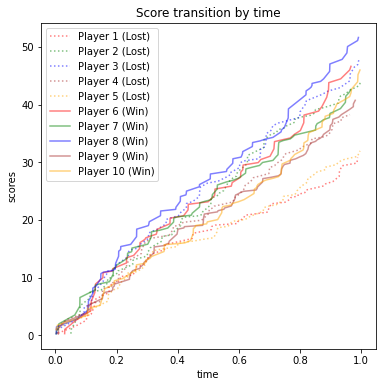

In [1]:
import experiment_vis_functions as vis

match_number = 'NA1_4100487908'

vis.score_per_player(save=False, model='challenger_spa', match=match_number)

# Scores per events of a player

In [34]:
import pandas as pd

# score_path = './processed_ftr/challenger_g3_score.csv' # PASTA by team
score_path = './processed_ftr/scores_challenger.csv' # PASTA by player
match_id = 'NA1_4100487908'
player = 7
pd.set_option("display.max_rows", None, "display.max_columns", None)
events = ['ITEM_PURCHASED', 'ITEM_SOLD',
       'ITEM_DESTROYED', 'SKILL_LEVEL_UP', 'LEVEL_UP', 'WARD_PLACED',
       'WARD_KILL', 'CHAMPION_KILL', 'CHAMPION_KILL_ASSIST',
       'CHAMPION_KILL_VICTIM', 'BUILDING_KILL', 'BUILDING_KILL_ASSIST',
       'ELITE_MONSTER_KILL', 'ELITE_MONSTER_KILL_ASSIST']

data = pd.read_csv(score_path)

data = data[(data['match_id'] == match_id) & (data['player'] == player)].drop(labels=['match_id', 'win'], axis='columns')
data = data.drop(labels=['mage', 'fighter', 'support', 'tank', 'assassin', 'marksman', 'TOP', 'MIDDLE', 'BOTTOM', 'JUNGLE', 'UTILITY'], axis='columns')

scoresums, counts, means = [], [], []
for event in events:
    event_scores = data[data[event] == 1]['score'].tolist()
    
    _sum = sum(event_scores)
    _count = len(event_scores)
    _mean = _sum / _count if _count != 0 else 0
    
    scoresums.append(_sum)
    counts.append(_count)
    means.append(_mean)
    
scoresum_per_event = {
    'event': events, 'sum of score': scoresums, 'count': counts, 'mean': means
}
scoresum_per_event = pd.DataFrame(scoresum_per_event).sort_values(by='sum of score', axis=0, ascending=False, ignore_index=True)
scoresum_per_event

,event,sum of score,count,mean
0,LEVEL_UP,12.515581,11,1.137780
1,SKILL_LEVEL_UP,11.433820,12,0.952818
2,WARD_PLACED,8.647016,22,0.393046
3,ITEM_PURCHASED,5.196471,16,0.324779
4,CHAMPION_KILL_ASSIST,4.841710,10,0.484171
5,ITEM_DESTROYED,3.570006,10,0.357001
6,CHAMPION_KILL,2.085938,3,0.695313
7,WARD_KILL,1.110261,3,0.370087
8,CHAMPION_KILL_VICTIM,1.076775,2,0.538387
9,BUILDING_KILL_ASSIST,0.659045,1,0.659045


# Total scores per event graph

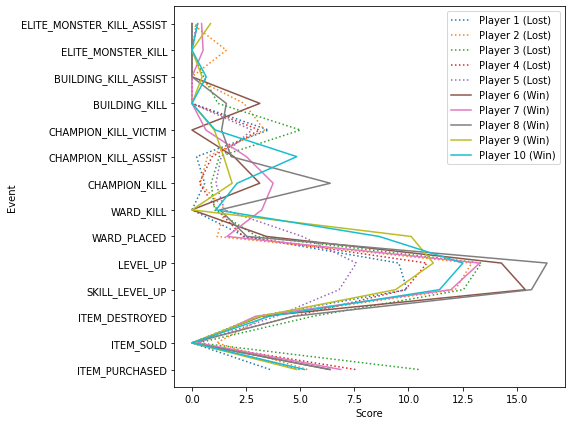

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# score_path = './processed_ftr/challenger_g3_score.csv' # PASTA by team
score_path = './processed_ftr/scores_challenger.csv' # PASTA by player
match_id = 'NA1_4100487908'
pd.set_option("display.max_rows", None, "display.max_columns", None)
events = ['ITEM_PURCHASED', 'ITEM_SOLD',
       'ITEM_DESTROYED', 'SKILL_LEVEL_UP', 'LEVEL_UP', 'WARD_PLACED',
       'WARD_KILL', 'CHAMPION_KILL', 'CHAMPION_KILL_ASSIST',
       'CHAMPION_KILL_VICTIM', 'BUILDING_KILL', 'BUILDING_KILL_ASSIST',
       'ELITE_MONSTER_KILL', 'ELITE_MONSTER_KILL_ASSIST']

data = pd.read_csv(score_path)
data = data[data['match_id']==match_id]

plt.figure(figsize=(7, 7))
plt.yticks([i for i in range(0, len(events))], events)
plt.xlabel('Score')
plt.ylabel('Event')
colors = ['red', 'green', 'blue', 'brown', 'orange']

for player in range(0, 10):
    tmp_data = data[(data['player'] == player+1)].drop(labels=['match_id'], axis='columns')
    tmp_data = tmp_data.drop(labels=['mage', 'fighter', 'support', 'tank', 'assassin', 'marksman', 'TOP', 'MIDDLE', 'BOTTOM', 'JUNGLE', 'UTILITY'], axis='columns')
    isWin = tmp_data['win'].iloc[0]

    scoresums = []
    for event in events:
        event_scores = tmp_data[tmp_data[event] == 1]['score'].tolist()
        
        _sum = sum(event_scores)
        scoresums.append(_sum)
    
    label = 'Player %i'%(player + 1) + (' (Win)' if isWin else ' (Lost)')
    plt.plot(scoresums, [i for i in range(0, len(scoresums))], label=label, ls='-' if isWin else ':')
    plt.gca().invert_yaxis()

plt.legend()
plt.show()

# Average scores per player for a event

In [1]:
import pandas as pd

# score_path = './processed_ftr/challenger_g3_score.csv' # PASTA by team
score_path = './processed_ftr/scores_challenger.csv' # PASTA by player
match_id = 'NA1_4100487908'

pd.set_option("display.max_rows", None, "display.max_columns", None)

data = pd.read_csv(score_path)

data = data[(data['match_id'] == match_id)].drop(labels=['match_id', 'win'], axis='columns')
data = data.drop(labels=['mage', 'fighter', 'support', 'tank', 'assassin', 'marksman', 'TOP', 'MIDDLE', 'BOTTOM', 'JUNGLE', 'UTILITY'], axis='columns')

scoresums, counts, means, maxes = [], [], [], []
data = data[(data['CHAMPION_KILL_VICTIM']==1)]
for player in range(10):
    event_scores = data[data['player'] == player+1]['score'].tolist()
    
    _sum = sum(event_scores)
    _count = len(event_scores)
    _mean = _sum / _count if _count != 0 else 0
    _max = max(event_scores) if _count != 0 else 0
    
    scoresums.append(_sum)
    counts.append(_count)
    means.append(_mean)
    maxes.append(_max)
    
scoresum_per_event = {
    'player': [i+1 for i in range(10)], 'sum of score': scoresums, 'count': counts, 'mean': means, 'max': maxes
}
scoresum_per_event = pd.DataFrame(scoresum_per_event).sort_values(by='mean', axis=0, ascending=False, ignore_index=True)
scoresum_per_event.style.hide_index()

player,sum of score,count,mean,max
3,5.013129,6,0.835522,1.088000
1,3.538665,5,0.707733,0.948097
5,2.766203,4,0.691551,0.965758
8,1.370055,2,0.685027,0.755377
2,3.349033,5,0.669807,0.781629
7,0.642855,1,0.642855,0.642855
4,3.112479,5,0.622496,0.699197
10,1.076775,2,0.538387,0.550238
9,1.033548,2,0.516774,0.567996
6,0.000000,0,0.000000,0.000000


# Event sequence of a player

In [17]:
import pandas as pd

# score_path = './processed_ftr/challenger_g3_score.csv' # PASTA by team
score_path = './processed_ftr/scores_challenger.csv' # PASTA by player
match_id = 'NA1_4100487908'
player = 7

pd.set_option("display.max_rows", None, "display.max_columns", None)
events = ['ITEM_PURCHASED', 'ITEM_SOLD',
       'ITEM_DESTROYED', 'SKILL_LEVEL_UP', 'LEVEL_UP', 'WARD_PLACED',
       'WARD_KILL', 'CHAMPION_KILL', 'CHAMPION_KILL_ASSIST',
       'CHAMPION_KILL_VICTIM', 'BUILDING_KILL', 'BUILDING_KILL_ASSIST',
       'ELITE_MONSTER_KILL', 'ELITE_MONSTER_KILL_ASSIST']

data = pd.read_csv(score_path)
# data = data[(data['match_id'] == match_id) & (data['player'] <= 5)]
data = data[(data['match_id'] == match_id) & (data['player'] == player)]
# data = data[(data['LEVEL_UP']==1) | (data['CHAMPION_KILL']==1) | (data['CHAMPION_KILL_ASSIST']) | (data['CHAMPION_KILL_VICTIM'])]
data.sort_values(by='time', inplace=True, ignore_index=True)

event_seq = []
for i in range(data.shape[0]):
    seq = {
        'player': data.loc[i, 'player'],
        'time': data.loc[i, 'time'],
        'x_position': data.loc[i, 'x_position'],
        'y_position': data.loc[i, 'y_position'],
        'deviation': data.loc[i, 'deviation'],
        'event_weight': data.loc[i, 'event_weight'],
        'score': data.loc[i, 'score']
    }
    for event in events:
        if data.loc[i, event] == 1: seq['event'] = event
    event_seq.append(seq)

event_seq = pd.DataFrame(event_seq)
event_seq

,player,time,x_position,y_position,deviation,event_weight,score,event
0,7,0.003239,1.000000,1.000000,0.377840,0.116667,0.251784,ITEM_PURCHASED
1,7,0.003664,1.000000,1.000000,0.333440,0.050000,0.253504,ITEM_PURCHASED
2,7,0.003864,1.000000,1.000000,0.344160,0.000000,0.256708,ITEM_PURCHASED
3,7,0.009245,1.000000,1.000000,0.486014,0.116667,0.260712,ITEM_PURCHASED
4,7,0.009770,1.000000,1.000000,0.467546,0.050000,0.264317,ITEM_PURCHASED
5,7,0.009970,1.000000,1.000000,0.463194,0.000000,0.277976,ITEM_PURCHASED
6,7,0.011722,1.000000,1.000000,0.523323,0.000000,0.416205,ITEM_PURCHASED
7,7,0.063537,0.481173,0.658790,0.293478,0.200000,1.526953,SKILL_LEVEL_UP
8,7,0.080003,0.513313,0.654951,0.254794,1.000000,1.521991,LEVEL_UP
9,7,0.080504,0.514290,0.654834,0.253727,0.200000,1.513748,SKILL_LEVEL_UP
